<img src='image/coverpicture.jpeg'>

# Predicting Hotel Reservation Cancellations

## Jae Heon Kim

# Overview

With the advent of the post-pandemic world, traditional travel industries are facing intense competition from tech-savvy rivals such as Airbnb who are attempting to revolutionize the industry. Given the economic uncertainties and rising wages, Hilton is aiming to optimize its workforce by identifying instances of reservation cancellations.

# Business Understanding

Hilton is a prominent hospitality brand in the hotel industry that faces stiff competition from non-traditional rivals like Airbnb in the tech-oriented post-pandemic world. Hilton is confronting challenges of accurately predicting its reservation cancellations as it holds the key to optimal allocation of resources without falling short of customers' expectations. While they can tolerate slight understaffing, they want to avoid overstaffing on any given day.

The objective of this project is to build a predictive model that accurately forecasts reservation cancellations. By using machine learning classification techniques such as logistic regression, decision trees, random forests, KNN, and Bayesian classification, we aim to deliver accurate predictions that enable Hilton to make data-driven decisions that can save them money by avoiding overstaffed labor.

# Data Understanding

## Data Introduction:

The dataset we are using is sourced from Kaggle Datasets and includes information on hotel reservations made between 2017 and 2018 for Hilton Hotel. There are 19 columns and 36275 rows in the dataset, one of which is the target variable `booking_status`, indicating whether a reservation was cancelled or confirmed. Our goal is to develop a model that accurately predicts this outcome using information from the other columns.

Other attributes of the data are contained in the data dictionary that follows:

## Data Dictionary:

`Booking_ID`: unique identifier of each booking

`no_of_adults`: Number of adults

`no_of_children`: Number of Children

`no_of_weekend_nights`: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel

`no_of_week_nights`: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel

`type_of_meal_plan`: Type of meal plan booked by the customer:

`required_car_parking_space`: Does the customer require a car parking space? (0 - No, 1- Yes)

`room_type_reserved`: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.

`lead_time`: Number of days between the date of booking and the arrival date

`arrival_year`: Year of arrival date

`arrival_month`: Month of arrival date

`arrival_date`: Date of the month

`market_segment_type`: Market segment designation.


`repeated_guest`: Is the customer a repeated guest? (0 - No, 1- Yes)

`no_of_previous_cancellations`: Number of previous bookings that were canceled by the customer prior to the current booking

`no_of_previous_bookings_not_canceled`: Number of previous bookings not canceled by the customer prior to the current booking

`avg_price_per_room`: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)

`no_of_special_requests`: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)

`booking_status`: Flag indicating if the booking was canceled or not.

## Imports

In [61]:
# Import basic packages
import pandas as pd
import numpy as np
import json
import copy

# Import visualization packages
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
%matplotlib inline

# Import scipy
import scipy as stats

# Import xgboost
from xgboost import XGBRegressor, XGBClassifier

# Import sklearn pacakages
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score,\
                                    GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing   import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder,\
                                    normalize
from sklearn.linear_model    import LinearRegression, LogisticRegression
from sklearn.tree            import plot_tree, DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.naive_bayes     import MultinomialNB, GaussianNB
from sklearn.ensemble        import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier,\
                                    ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics         import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,\
                                    classification_report, r2_score, mean_squared_error, mean_absolute_error,\
                                    ConfusionMatrixDisplay, RocCurveDisplay, log_loss, confusion_matrix
from sklearn.pipeline        import Pipeline
from sklearn.compose         import ColumnTransformer
from sklearn.impute          import SimpleImputer
from sklearn                 import set_config
set_config(display= 'diagram')

## Functions
Below are newly-defined functions to increase efficiency and readability.

In [2]:
# Instantiate global variable model_results_dict
model_results_dict = dict()

def find_best_model(model_pipe, model_grid, X_train, y_train, scoring='precision'):
    """
    This function trains the best logistic regression model using GridSearchCV on the given parameter grid and 
    returns the fitted model.
    """
    # Build the best pipeline
    model_search_grid_cv = GridSearchCV(estimator=model_pipe, param_grid=model_grid, scoring=scoring)

    # Fit the pipeline to training data
    model_search_grid_cv.fit(X_train, y_train)

    # Print the best hyperparameters choice
    print(f'Best hyperparameters: {model_search_grid_cv.best_params_}')
    print(f'Best {scoring} score: {model_search_grid_cv.best_score_:.3f}')

    # Instantiate the best model
    best_model = model_search_grid_cv.best_estimator_

    # Fit the training data to the best logistic regression model
    best_model.fit(X_train, y_train)
    display(best_model)
    return best_model


def perform_cross_validation(model, X_train, y_train):
    """This function performs and prints out cross validation results."""
    # Cross_validate
    cv_results = cross_validate(model, X_train, y_train, cv=10, 
                                scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

    # Print mean scores for each metric
    print_cross_validation(cv_results)


def print_cross_validation(cv_results):
    """This function performs and prints out cross validation results."""
    # Print the cross validation results
    print("Accuracy:      ", round(cv_results['test_accuracy'].mean(), 3))
    print("Precision:     ", round(cv_results['test_precision'].mean(), 3))
    print("Recall:        ", round(cv_results['test_recall'].mean(), 3))
    print("F1 Score:      ", round(cv_results['test_f1'].mean(), 3))
    print("ROC AUC Score: ", round(cv_results['test_roc_auc'].mean(), 3))

    
def print_classification_report(y_test, y_pred):
    """This function prints out the classification report."""
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    
    
def test_results(model_name, y_test, y_pred, y_pred_proba):
    """This function computes/stores test results metrics into a dictionary and prints each metric individually."""
    # Compute Metrics
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred), 3)
    roc = round(roc_auc_score(y_test, y_pred_proba), 3)
    
    # Call dictionary
    global model_result_dict
    
    # Store metrics in dictionary
    model_results_dict[model_name] = {'accuracy':accuracy, 'precision':precision, 'recall':recall, 'f1':f1, 'roc':roc}
    
    # Print metrics
    print('\n\n')
    print(f"{model_name.title()}'s Metrics:")
    print('accuracy: ', accuracy)
    print('precision:', precision)
    print('recall:   ', recall)
    print('f1:       ', f1)
    print('roc:      ', roc, '\n\n')
    
    
def visualize_test_results(model_name, model, X_test, y_test):
    """This function plots confusion matrix and roc-auc curve of the best model."""
    # Display visualizations on test results
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Plot confusion matrix on the left
    cm_display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax[0])
    cm_display.ax_.set_title("Confusion Matrix")

    # Plot ROC curve on the right
    roc_display = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax[1])
    roc_display.ax_.set_title("ROC Curve")

    # Display
    plt.suptitle(f"Results of {model_name.title()} Model")
    plt.tight_layout()
    plt.show()

## Data Description and Understanding

We will start by observing the raw data.

In [62]:
# Call data and display
df = pd.read_csv('data/data.csv')
display(df.info())

# Make a deep-copy of the original data
df_copy = copy.deepcopy(df)

# Check for data's length
print("\n\ndf's length:", len(df.index))

# Check for unavailabe data 
print("\n\nThe total sum of unavailable values for each column:")
display(df.isna().sum())

# Check dataframe
print("\n\n")
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

None



df's length: 36275


The total sum of unavailable values for each column:


Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


Based on the output, there seems to be little to no imputations to be done. However, final decisions on imputation will be made after detailful assessment of each column.

In [4]:
# Pull detailed information about each column
for column in df.columns:
    print(f'{column}:')
    print('total unique entries in column:', df[column].nunique())
    print(df[column].unique())
    print(df[column].value_counts(normalize=True), '\n\n\n')

Booking_ID:
total unique entries in column: 36275
['INN00001' 'INN00002' 'INN00003' ... 'INN36273' 'INN36274' 'INN36275']
INN00001    0.000028
INN24187    0.000028
INN24181    0.000028
INN24182    0.000028
INN24183    0.000028
              ...   
INN12086    0.000028
INN12085    0.000028
INN12084    0.000028
INN12083    0.000028
INN36275    0.000028
Name: Booking_ID, Length: 36275, dtype: float64 



no_of_adults:
total unique entries in column: 5
[2 1 3 0 4]
2    0.719724
1    0.212130
3    0.063873
0    0.003832
4    0.000441
Name: no_of_adults, dtype: float64 



no_of_children:
total unique entries in column: 6
[ 0  2  1  3 10  9]
0     0.925624
1     0.044604
2     0.029166
3     0.000524
9     0.000055
10    0.000028
Name: no_of_children, dtype: float64 



no_of_weekend_nights:
total unique entries in column: 8
[1 2 0 4 3 6 5 7]
0    0.465114
1    0.275534
2    0.250062
3    0.004218
4    0.003556
5    0.000937
6    0.000551
7    0.000028
Name: no_of_weekend_nights, dtype: floa

After conducting a brief survey of each column, some columns seem to contribute little to predictive task at hand:

- `Booking_ID` - This serves not much purpose other than notational indexing.
- `arrival_year` - This has binary value of 2017 and 2018, which do not have enough power to tell different stories. While situations can vary due to seasonal changes in different months and deadlines of businesses on varying dates, the binary value of 2017 and 2018 for the 'arrival_year' column may not provide sufficient information to draw meaningful insights. Also, while this feature can classifying past data, it's no longer meaningful since there will be no more reservations made in years 2017 and 2018.

We also noticed some numeric columns that are better left as categorical columns:
- `required_car_parking_space` - The entries are either 0 for 'no' and 1 for 'yes. This is binary categorical values since the answers do not have mathematical magnitude for interpretation. 
- `repeated_guest` - The entries are either 0 for 'no' and 1 for 'yes. This is binary categorical values since the answers do not have mathematical magnitude for interpretation.
- `arrival_month` - The months are in integer form from 1 to 12, with each entry representing n-th month of the year. Likewise, third month of the year isn't 3 times the first. These are just numrical names given to a categorical data.
- `arrival_date` - This follows the same reasoning from the previous.


In [5]:
# Drop unnecessary columns
df = df.drop(['Booking_ID', 'arrival_year'], axis=1)

# Change numeric data types to categorical data types
df['required_car_parking_space'] = df['required_car_parking_space'].replace({1: 'Yes', 0: 'No'}).astype('category')
df['repeated_guest'] = df['repeated_guest'].replace({1: 'Yes', 0: 'No'}).astype('category')
df['arrival_month'] = df['arrival_month'].astype('category')
df['arrival_date'] = df['arrival_date'].astype('category')

# Change object data types to categorical data types
df['type_of_meal_plan'] = df['type_of_meal_plan'].astype('category')
df['room_type_reserved'] = df['room_type_reserved'].astype('category')
df['market_segment_type'] = df['market_segment_type'].astype('category')

# Change the target variable's data type to numerical for correlation heatmap and pairplot
df['booking_status'] = df['booking_status'].replace({'Not_Canceled': 1, 'Canceled': 0}).astype(int)

# Check the changes
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   no_of_adults                          36275 non-null  int64   
 1   no_of_children                        36275 non-null  int64   
 2   no_of_weekend_nights                  36275 non-null  int64   
 3   no_of_week_nights                     36275 non-null  int64   
 4   type_of_meal_plan                     36275 non-null  category
 5   required_car_parking_space            36275 non-null  category
 6   room_type_reserved                    36275 non-null  category
 7   lead_time                             36275 non-null  int64   
 8   arrival_month                         36275 non-null  category
 9   arrival_date                          36275 non-null  category
 10  market_segment_type                   36275 non-null  category
 11  re

None

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,Meal Plan 1,No,Room_Type 1,224,10,2,Offline,No,0,0,65.00,0,1
1,2,0,2,3,Not Selected,No,Room_Type 1,5,11,6,Online,No,0,0,106.68,1,1
2,1,0,2,1,Meal Plan 1,No,Room_Type 1,1,2,28,Online,No,0,0,60.00,0,0
3,2,0,0,2,Meal Plan 1,No,Room_Type 1,211,5,20,Online,No,0,0,100.00,0,0
4,2,0,1,1,Not Selected,No,Room_Type 1,48,4,11,Online,No,0,0,94.50,0,0


We will now draw pairplots and heatmaps to gain more insights about the relationship between predictor variables and the target variable.

In [ ]:
# Draw a pairplot
sns.pairplot(df.sample(200))
plt.show()

/var/folders/wk/9bjhpgp97cn4h0z79qcdtkdr0000gp/T/ipykernel_92822/313186905.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = abs(df.corr())


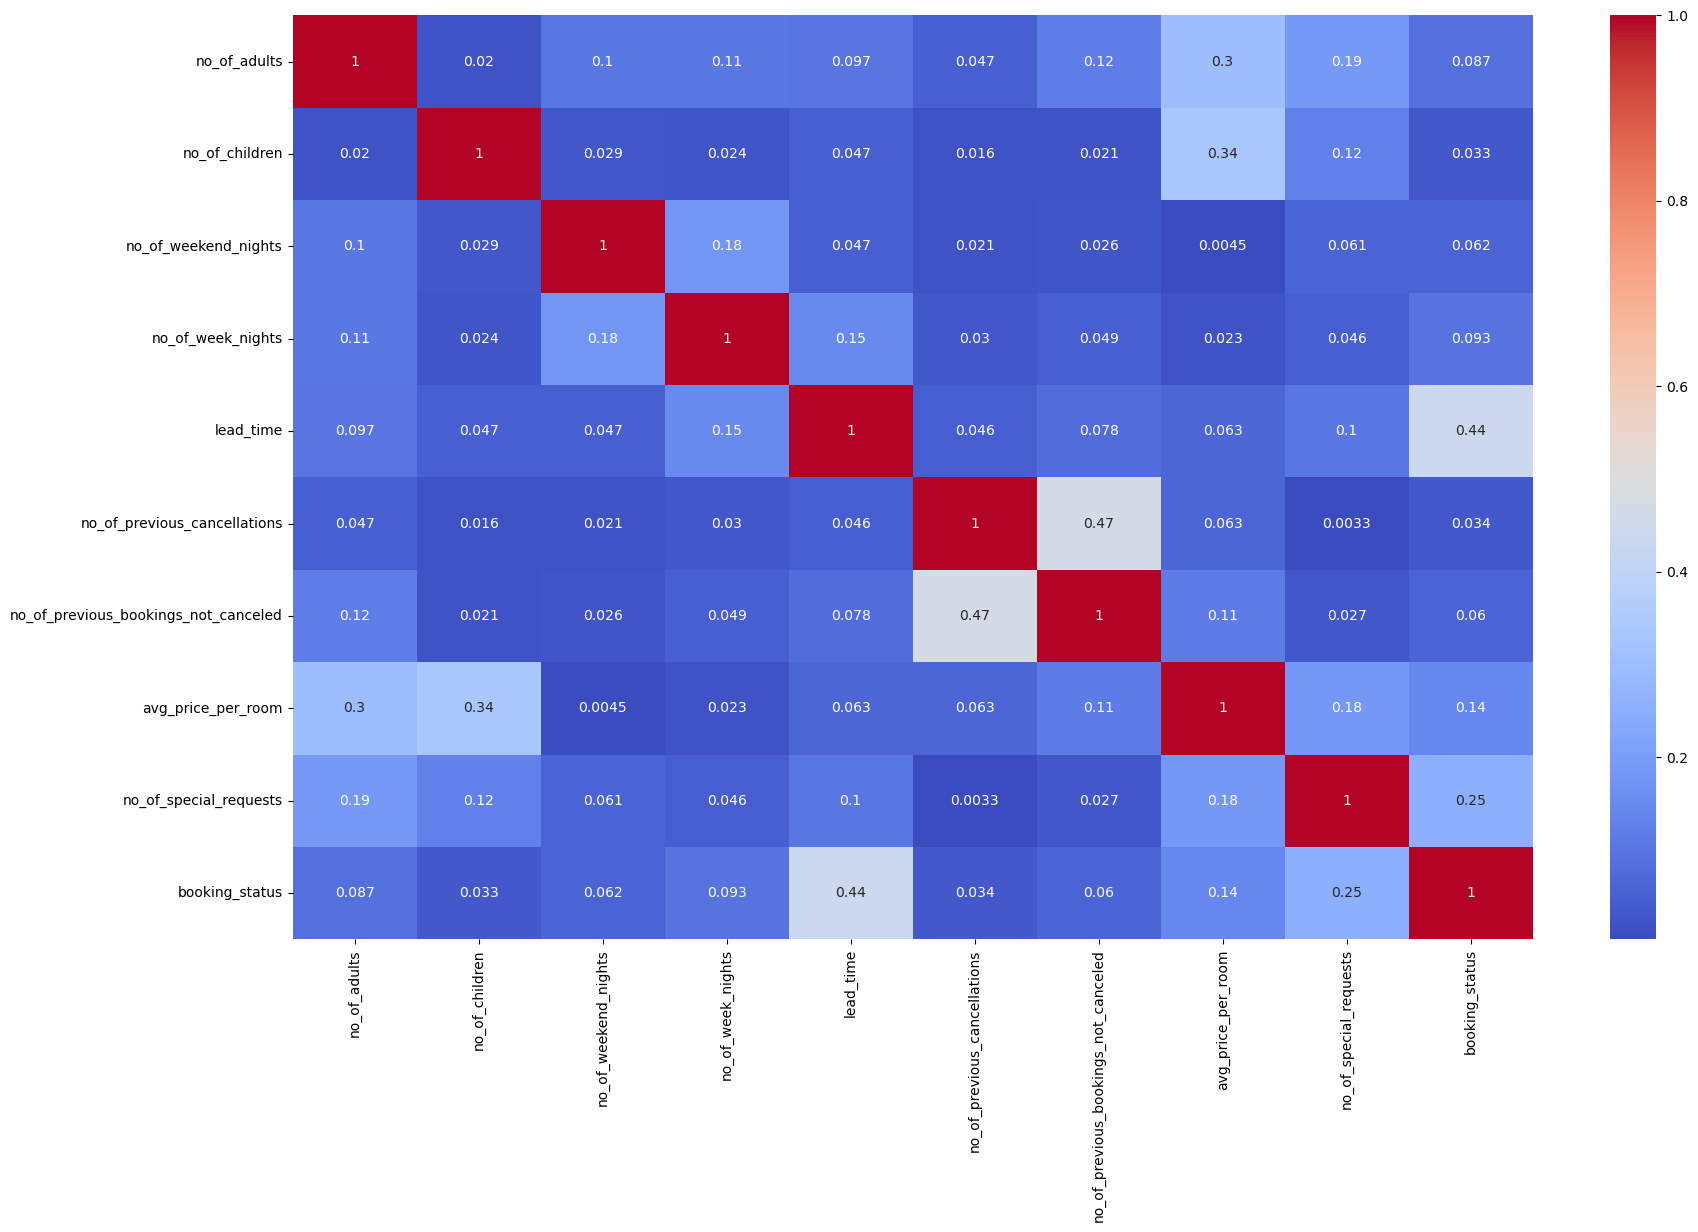

In [7]:
# Create a correlation matrix
corr = abs(df.corr())

# Draw a correlation heatmap
fig, ax = plt.subplots(figsize=(20,12))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

Based on the visual aids from pairplot and correlation heatmap, we can say there is not enough strong linear relationship with the `booking_status` and predictor variables. The only possible consideration would be `lead_time`, but still it's not strong enough at correlation coefficient of 0.44.

We swithced the target variable's data type to numeric to observe its relationship with predictor variables through pairplot and correlation heatmap but it will be classified again as categorical data of binary values, as it should be, for the remainder of the study.

Lastly, with careful observation of each column, we may conclude that no further imputations are necessary.

In [8]:
# Change the target variable's data type to numerical for correlation heatmap and pairplot
df['booking_status'] = df['booking_status'].replace({1:'Not_Canceled', 0:'Canceled'}).astype('category')

# Data Preparation

## Organizing Columns by Data Type

In [9]:
# Define column-list for different predictor variables
numeric_cols = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'lead_time',
                'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
                'avg_price_per_room', 'no_of_special_requests']
nominal_cols = ['type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 'arrival_month', 
                'arrival_date', 'market_segment_type', 'repeated_guest']

# Define target column
target_cols = ['booking_status']

## Understanding Target Variable
Check what proportions bookings end up in cancellations.

In [10]:
# Pull value counts of the `booking_status`
print("booking_status:")
print(df.booking_status.value_counts(normalize=True))

booking_status:
Not_Canceled    0.672364
Canceled        0.327636
Name: booking_status, dtype: float64


Also visualize this information.

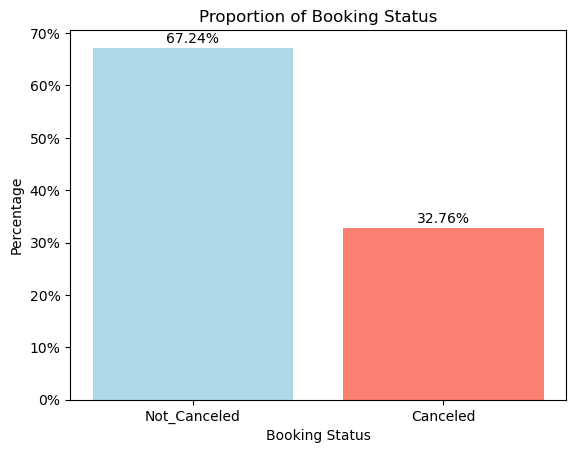

In [100]:

# Define the data
booking_status = ['Not_Canceled', 'Canceled']
values = [0.672364, 0.327636]

# Define the colors for each bar
colors = ['lightblue', 'salmon']

# Create the bar plot
fig, ax = plt.subplots()
ax.bar(booking_status, values, color=colors)

# Add labels and title
ax.set_xlabel('Booking Status')
ax.set_ylabel('Percentage')
ax.set_title('Proportion of Booking Status')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

# Add value of each bar in the legend
for i, v in enumerate(values):
    ax.text(i, v + 0.01, "{:.2%}".format(v), ha='center')

# Display and save the plot
plt.savefig('booking_status.png')
plt.show()


Approximately every 1 booking out of 3 bookings get cancelled. We want to build models that far surpass this.
Now we will encode the target variable so that it's ready for use in developing machine learning models.

## Encoding: Target Variable

In [12]:
# Encode the target variable
le = LabelEncoder()
df['booking_status'] = le.fit_transform(df['booking_status'])

## Defining Training Set and Testing Set

In [13]:
# Define predictor variables X, and target variable y
X = df.drop('booking_status', axis=1)
y = df['booking_status']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=817)

## Defining Pipelines and Column-Transformers

In [14]:
# Define pipelines for numerical and nominal columns separately
numeric_pipeline = Pipeline([('num_imputer', SimpleImputer(strategy = 'mean')), 
                             ('ss', StandardScaler())])
nominal_pipeline = Pipeline([('ohe_imputer', SimpleImputer(strategy = 'most_frequent')),
                             ('ohe', OneHotEncoder(sparse_output = False, drop = 'first', handle_unknown='ignore'))])

# Instantiate column-transformer
ct = ColumnTransformer([("nominal_pipeline", nominal_pipeline, nominal_cols),
                        ("numeric_pipeline", numeric_pipeline, numeric_cols)])

# Modeling

In the modeling and evaluation process, we will generate every type of classification model at least once. For outperforming models, subsequent runs of different hyperparameters will be made in search for a better outcome. Only the latest of those versions will be kept since to keep the notebook concise to the point from tedious repetitions. This should also help reduce the cell's run time.

We will then compare different models and choose the top-performers and combine them together into an ensemble classifier in search of improved performance.

Lastly, we will compare the ensemble models to decide which one will be our final model

## Logistic Regression Model

In [15]:
# Make a final pipeline
logreg_pipe = Pipeline([('preprocess', ct),
                      ('logreg', LogisticRegression(random_state=817, solver='liblinear', max_iter=1000))])

# Make a search-grid for the best pipeline
logreg_grid = {'logreg__C': [10, 100]}

# Find the best model, train and fit it, print outcome
logreg_model = find_best_model(logreg_pipe, logreg_grid, X_train, y_train, scoring='precision')


Best hyperparameters: {'logreg__C': 100}
Best precision score: 0.834


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['type_of_meal_plan',
                                                   'required_car_parking_space',
                                                   'room_type_reserved',
                                                   'arrival_month',
                                                   'arrival_date',
                                                   'market_segm...
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['no_of_adults',
                                                   'no_of_children',
                                                   'no_of_weekend_nights',
                                                   'no_of_week_nights',
                                                   'lead_time',
                                                   'no_of_previous_cancellations',
                                                   'no_of_previous_bookings_not_canceled',
                                                   'avg_price_per_room',
                                                   'no_of_special_requests'])])),
                ('logreg',
                 LogisticRegression(C=100, max_iter=1000, random_state=817,
                                    solver='liblinear'))])

Now, that our best model has been formualted, we will cross-validate the training set in 10-folds.

In [16]:
# Cross_validate
perform_cross_validation(logreg_model, X_train, y_train)

Accuracy:       0.806
Precision:      0.835
Recall:         0.888
F1 Score:       0.86
ROC AUC Score:  0.872


In [17]:
# Also check log-loss ond data
print('train log-loss: ', round(log_loss(y_train, logreg_model.predict_proba(X_train)), 3))
print('test log-loss:  ', round(log_loss(y_test, logreg_model.predict_proba(X_test)), 3))

train log-loss:  0.409
test log-loss:   0.412


The errors were not as low as what we want to accomplish, but similar magnitude of error was an indication that the model wasn't overfitting.

Now we will evaluate our model's performance on actual test data by accessing classification report, confusion matrix and ROC curve.

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.62      0.68      3922
           1       0.83      0.89      0.86      8049

    accuracy                           0.80     11971
   macro avg       0.78      0.76      0.77     11971
weighted avg       0.80      0.80      0.80     11971




Logistic Regression's Metrics:
accuracy:  0.804
precision: 0.829
recall:    0.894
f1:        0.86
roc:       0.871 




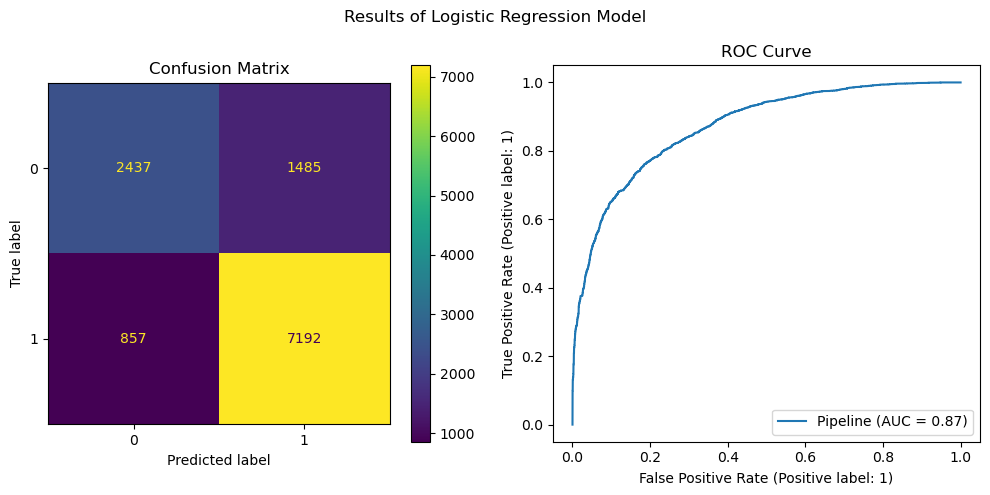

In [18]:
# Predict y-values
y_pred_logreg = logreg_model.predict(X_test)
y_pred_proba_logreg = logreg_model.predict_proba(X_test)[:, 1]

# Print classification report on the best model
print_classification_report(y_test, y_pred_logreg)

# Print test metrics and store it in a dictionary
test_results('logistic regression', y_test, y_pred_logreg, y_pred_proba_logreg)

# Display confusion matrix and roc-auc curve
visualize_test_results("logistic regression", logreg_model, X_test, y_test)

<b>Comments on Logistic Regression Model:</b>
- `Accuracy score of 0.80` is high, but not high enough to meet stakeholders' expectations.
- The stakeholders wants to avoid overstaffing and doesn't mind understaffing. In this circumstance, our model needs to have lowest false positive rate possible, which is achieved when we have highest precision. In this model, `precision is 0.83`. We look forward to get better results with subsequent models.
- We will consider this as the baseline model.

## Decision Tree Model

In [19]:
# Make a final pipeline
dt_pipe = Pipeline([('preprocess', ct),
                      ('dt', DecisionTreeClassifier(random_state=817, criterion='entropy'))])

# Make a search-grid for the best pipeline
dt_grid = {'dt__max_depth': [24, 25],
        'dt__min_samples_leaf': [1, 2],
        'dt__min_samples_split': [1, 2]}

# Find the best model, train and fit it, print outcome
dt_model = find_best_model(dt_pipe, dt_grid, X_train, y_train, scoring='precision')

Best hyperparameters: {'dt__max_depth': 24, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 1}
Best precision score: 0.905


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['type_of_meal_plan',
                                                   'required_car_parking_space',
                                                   'room_type_reserved',
                                                   'arrival_month',
                                                   'arrival_date',
                                                   'market_segm...
                                                                   StandardScaler())]),
                                                  ['no_of_adults',
                                                   'no_of_children',
                                                   'no_of_weekend_nights',
                                                   'no_of_week_nights',
                                                   'lead_time',
                                                   'no_of_previous_cancellations',
                                                   'no_of_previous_bookings_not_canceled',
                                                   'avg_price_per_room',
                                                   'no_of_special_requests'])])),
                ('dt',
                 DecisionTreeClassifier(criterion='entropy', max_depth=24,
                                        min_samples_leaf=2, min_samples_split=1,
                                        random_state=817))])

Now, that our best model has been formualted, we will cross-validate the training set in 10-folds.

In [20]:
# Cross_validate
perform_cross_validation(dt_model, X_train, y_train)

Accuracy:       0.86
Precision:      0.905
Recall:         0.884
F1 Score:       0.894
ROC AUC Score:  0.887


We've got impressive results with our training data. Let's see if same will hold with our test data.

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.80      3922
           1       0.90      0.90      0.90      8049

    accuracy                           0.87     11971
   macro avg       0.85      0.85      0.85     11971
weighted avg       0.87      0.87      0.87     11971




Decision Tree's Metrics:
accuracy:  0.866
precision: 0.901
recall:    0.898
f1:        0.9
roc:       0.892 




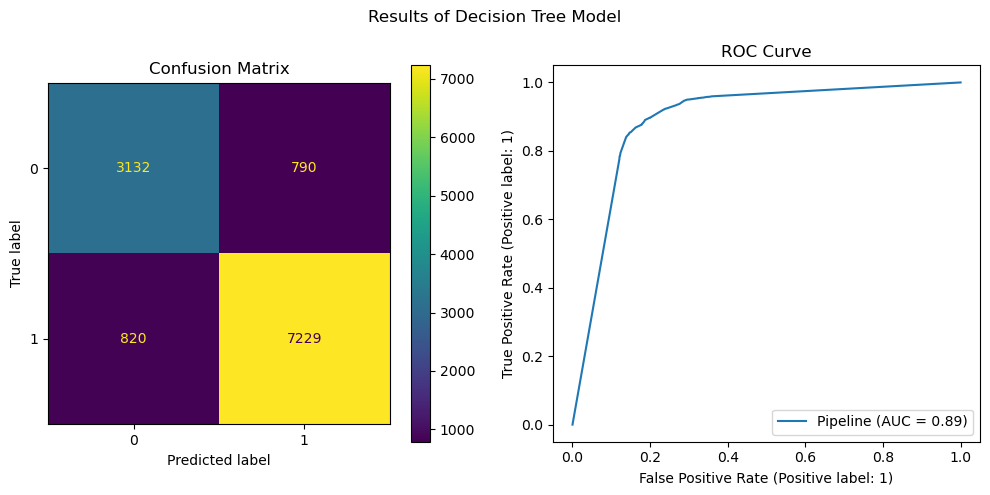

In [21]:
# Predict y-values
y_pred_dt = dt_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)[:,1]

# Print classification report on the best model
print_classification_report(y_test, y_pred_dt)

# Print test metrics and store it in a dictionary
test_results('decision tree', y_test, y_pred_dt, y_pred_proba_dt)

# Display confusion matrix and roc-auc curve
visualize_test_results("decision tree", dt_model, X_test, y_test)

<b>Comments on Decision Trees Model:</b>
- We are happy to see that results on the holdout set is very similar to the cross-validation results, an indication that our model is reliably consistent.
- For this model, `accuracy is 0.87` and `precision is 0.90`, yet another improvement on model's performance.

## K-Nearest-Neighbors Model

In [22]:
# Make a final pipeline
knn_pipe = Pipeline([('preprocess', ct),
                      ('knn', KNeighborsClassifier(n_neighbors=15, weights='distance'))])

# Make a search-grid for the best pipeline
knn_grid = {'knn__p': [4, 5]}

# Find the best model, train and fit it, print outcome
knn_model = find_best_model(knn_pipe, knn_grid, X_train, y_train, scoring='precision')

Best hyperparameters: {'knn__p': 4}
Best precision score: 0.886


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['type_of_meal_plan',
                                                   'required_car_parking_space',
                                                   'room_type_reserved',
                                                   'arrival_month',
                                                   'arrival_date',
                                                   'market_segm...
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['no_of_adults',
                                                   'no_of_children',
                                                   'no_of_weekend_nights',
                                                   'no_of_week_nights',
                                                   'lead_time',
                                                   'no_of_previous_cancellations',
                                                   'no_of_previous_bookings_not_canceled',
                                                   'avg_price_per_room',
                                                   'no_of_special_requests'])])),
                ('knn',
                 KNeighborsClassifier(n_neighbors=15, p=4,
                                      weights='distance'))])

Now perform the cross validation on training set.

In [23]:
# Cross_validate
perform_cross_validation(knn_model, X_train, y_train)

Accuracy:       0.865
Precision:      0.888
Recall:         0.915
F1 Score:       0.901
ROC AUC Score:  0.928


The validation results indicate noticeably better strength at detecting false negatives. Other metrics also show meaningful strength. Let's try this model on test data set.

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78      3922
           1       0.88      0.92      0.90      8049

    accuracy                           0.86     11971
   macro avg       0.85      0.83      0.84     11971
weighted avg       0.86      0.86      0.86     11971




K-Nearest Neighbors's Metrics:
accuracy:  0.862
precision: 0.881
recall:    0.918
f1:        0.899
roc:       0.923 




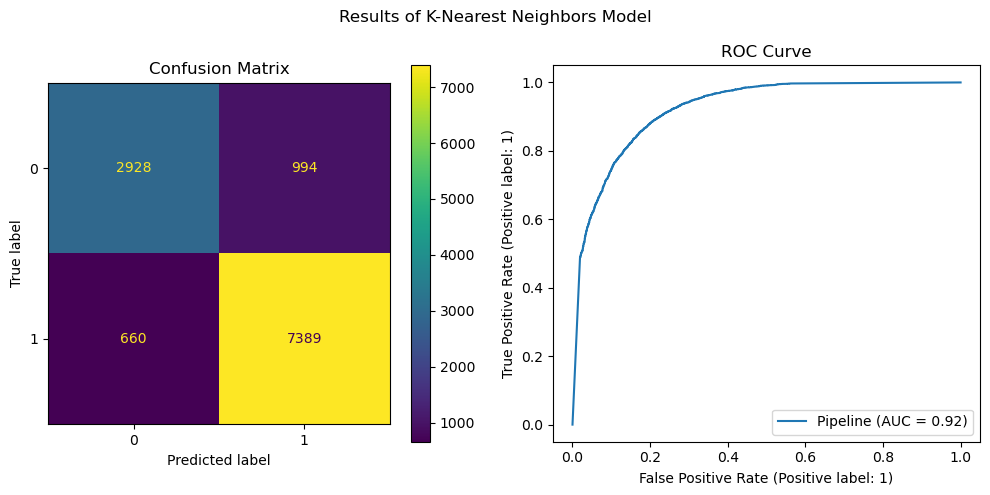

In [24]:
# Predict y-values
y_pred_knn = knn_model.predict(X_test)
y_pred_proba_knn = knn_model.predict_proba(X_test)[:,1]

# Print classification report on the best model
print_classification_report(y_test, y_pred_knn)

# Print test metrics and store it in a dictionary
test_results('k-nearest neighbors', y_test, y_pred_knn, y_pred_proba_knn)

# Display confusion matrix and roc-auc curve
visualize_test_results("k-nearest neighbors", knn_model, X_test, y_test)

<b>Comments on K-Nearest Neighbors Model:</b>
- This model performs worse than the decision tree model in detecting false positives. 
- It does a slightly better job at detecting false negatives.

## Bayes Classification Model

In [25]:
# Make a final pipeline
gnb_pipe = Pipeline([('preprocess', ct),
                      ('gnb', GaussianNB())])

# Make a search-grid for the best pipeline
gnb_grid = {'gnb__var_smoothing': [1e-10, 1e-5, 1e-3, 1e-2, 1e-1]}

# Find the best model, train and fit it, print outcome
gnb_model = find_best_model(gnb_pipe, gnb_grid, X_train, y_train, scoring='precision')

Best hyperparameters: {'gnb__var_smoothing': 0.1}
Best precision score: 0.934


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['type_of_meal_plan',
                                                   'required_car_parking_space',
                                                   'room_type_reserved',
                                                   'arrival_month',
                                                   'arrival_date',
                                                   'market_segm...
                                                   'repeated_guest']),
                                                 ('numeric_pipeline',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['no_of_adults',
                                                   'no_of_children',
                                                   'no_of_weekend_nights',
                                                   'no_of_week_nights',
                                                   'lead_time',
                                                   'no_of_previous_cancellations',
                                                   'no_of_previous_bookings_not_canceled',
                                                   'avg_price_per_room',
                                                   'no_of_special_requests'])])),
                ('gnb', GaussianNB(var_smoothing=0.1))])

Perform cross-validation on training data.

In [26]:
# Cross_validate
perform_cross_validation(gnb_model, X_train, y_train)

Accuracy:       0.559
Precision:      0.936
Recall:         0.369
F1 Score:       0.529
ROC AUC Score:  0.819


The accuracy of prediction is worse than our baseline logistic regression model. It however, does surprisingly well with the metrics of our interest, precision. Let's further see how this model does on the test datta.

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.94      0.58      3922
           1       0.93      0.38      0.53      8049

    accuracy                           0.56     11971
   macro avg       0.68      0.66      0.56     11971
weighted avg       0.76      0.56      0.55     11971




Bayes Classification's Metrics:
accuracy:  0.561
precision: 0.928
recall:    0.375
f1:        0.535
roc:       0.821 




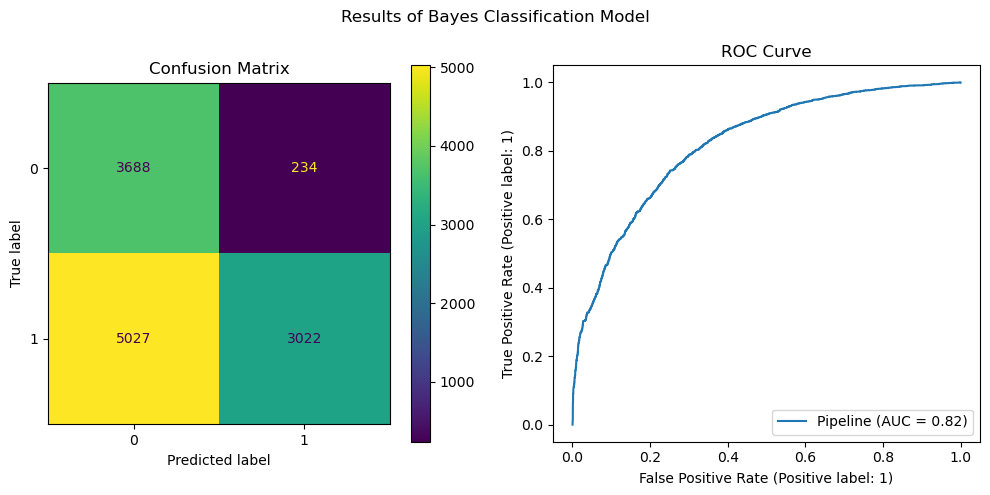

In [27]:
# Predict y-values
y_pred_gnb = gnb_model.predict(X_test)
y_pred_proba_gnb = gnb_model.predict_proba(X_test)[:,1]

# Print classification report on the best model
print_classification_report(y_test, y_pred_gnb)

# Print test metrics and store it in a dictionary
test_results('bayes classification', y_test, y_pred_gnb, y_pred_proba_gnb)

# Display confusion matrix and roc-auc curve
visualize_test_results("bayes classification", gnb_model, X_test, y_test)

<b>Comments on Bayes Classification Model:</b>
- The results on training data and test data are close which is what we want. When this model predicts that a customer will honor his reservation, it correctly predicts it 94% of time, the best performance so far. 
- However, it does terribly on overall prediction so this model alone is not reliable as its prediction on every other metrics are worse than random chances.

## Random Forests Model

In [28]:
# Make a final pipeline
rf_pipe = Pipeline([('preprocess', ct),
                      ('rf', RandomForestClassifier(random_state= 817, min_samples_split=1, min_samples_leaf=1,
                                                    criterion='gini', max_depth=30))])

# Make a search-grid for the best pipeline
rf_grid = {'rf__n_estimators': [400, 425]}

# Find the best model, train and fit it, print outcome
rf_model = find_best_model(rf_pipe, rf_grid, X_train, y_train, scoring='precision')

Best hyperparameters: {'rf__n_estimators': 425}
Best precision score: 0.905


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['type_of_meal_plan',
                                                   'required_car_parking_space',
                                                   'room_type_reserved',
                                                   'arrival_month',
                                                   'arrival_date',
                                                   'market_segm...
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['no_of_adults',
                                                   'no_of_children',
                                                   'no_of_weekend_nights',
                                                   'no_of_week_nights',
                                                   'lead_time',
                                                   'no_of_previous_cancellations',
                                                   'no_of_previous_bookings_not_canceled',
                                                   'avg_price_per_room',
                                                   'no_of_special_requests'])])),
                ('rf',
                 RandomForestClassifier(max_depth=30, min_samples_split=1,
                                        n_estimators=425, random_state=817))])

We will now evaluate this model's performance on the train-validation folds.

In [29]:
# Cross_validate
perform_cross_validation(rf_model, X_train, y_train)

Accuracy:       0.9
Precision:      0.907
Recall:         0.949
F1 Score:       0.927
ROC AUC Score:  0.953


The overall performance is impressive with all metrics. Hopefully, this will be also true on the test data set. 

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      3922
           1       0.90      0.95      0.93      8049

    accuracy                           0.90     11971
   macro avg       0.90      0.87      0.88     11971
weighted avg       0.90      0.90      0.90     11971




Random Forests's Metrics:
accuracy:  0.899
precision: 0.902
recall:    0.952
f1:        0.927
roc:       0.95 




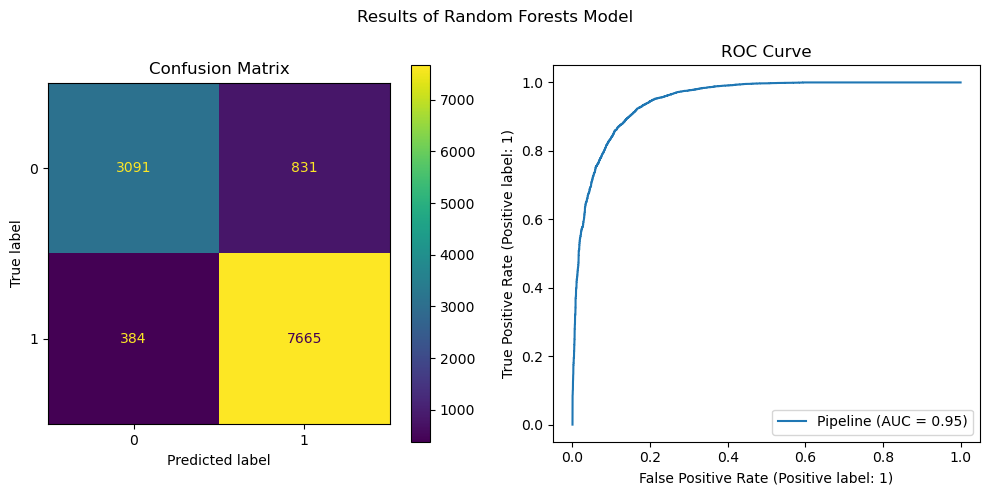

In [30]:
# Predict y-values
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:,1]

# Print classification report on the best model
print_classification_report(y_test, y_pred_rf)

# Print test metrics and store it in a dictionary
test_results('random forests', y_test, y_pred_rf, y_pred_proba_rf)

# Display confusion matrix and roc-auc curve
visualize_test_results("random forests", rf_model, X_test, y_test)

<b>Comments on Random Forests Model:</b>
- This model is best performing so far.
- However, this model falls short of our expectations for precision considering its wonderful performance on all other metrics.

## XG Boost Model

In [31]:
# Make a final pipeline
xgb_pipe = Pipeline([('preprocess', ct),
                      ('xgb', XGBClassifier(random_state=817, objective='binary:logistic', learning_rate=0.3, 
                                            colsample_bytree=0.75, gamma=1, max_depth=13))])
                       
# Make a search-grid for the best pipeline
xgb_grid = {'xgb__n_estimators': [175, 200]}


# Find the best model, train and fit it, print outcome
xgb_model = find_best_model(xgb_pipe, xgb_grid, X_train, y_train, scoring='precision')

Best hyperparameters: {'xgb__n_estimators': 200}
Best precision score: 0.909


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['type_of_meal_plan',
                                                   'required_car_parking_space',
                                                   'room_type_reserved',
                                                   'arrival_month',
                                                   'arrival_date',
                                                   'market_segm...
                               feature_types=None, gamma=1, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.3,
                               max_bin=256, max_cat_threshold=64,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=13, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=200, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=817, ...))])

Now, the best model is ready for cross validation.

In [32]:
# Cross_validate
perform_cross_validation(xgb_model, X_train, y_train)

Accuracy:       0.896
Precision:      0.911
Recall:         0.937
F1 Score:       0.924
ROC AUC Score:  0.953


This is impressive metrics all over. Let's try this model on the test data.

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      3922
           1       0.90      0.94      0.92      8049

    accuracy                           0.89     11971
   macro avg       0.89      0.87      0.88     11971
weighted avg       0.89      0.89      0.89     11971




Xg Boost's Metrics:
accuracy:  0.892
precision: 0.903
recall:    0.941
f1:        0.922
roc:       0.951 




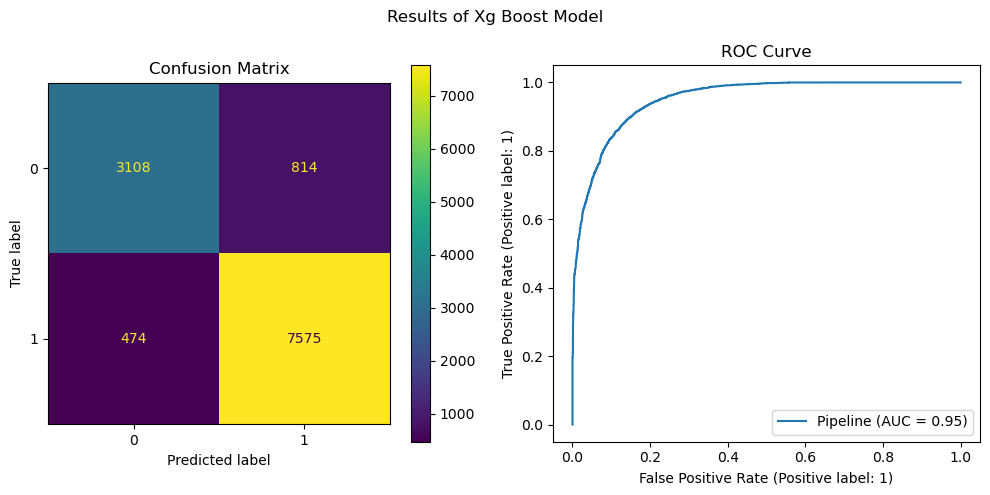

In [33]:
# Predict y-values
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:,1]

# Print classification report on the best model
print_classification_report(y_test, y_pred_xgb)

# Print test metrics and store it in a dictionary
test_results('xg boost', y_test, y_pred_xgb, y_pred_proba_xgb)

# Display confusion matrix and roc-auc curve
visualize_test_results("xg boost", xgb_model, X_test, y_test)

<b>Comments on XG Boost Model:</b>
- This model has done the best job at predicting.
- While we are happy with all metrics, we want to know if we can improve precision a slightly more.
- We will tune hyperparamets with this model to see if we can come up with an improved model, especially better at precision.

## Comparing Individual Models
After obtaining the best model for each classification model type, we need to compare their performances to decide which ones we will keep for creating combined models. We will study our results on individual models.

In [34]:
# Turn model results to dataframe
model_results_df = pd.DataFrame(model_results_dict)
model_results_df = model_results_df.reset_index()
model_results_df 

,index,logistic regression,decision tree,k-nearest neighbors,bayes classification,random forests,xg boost
0,accuracy,0.804,0.866,0.862,0.561,0.899,0.892
1,precision,0.829,0.901,0.881,0.928,0.902,0.903
2,recall,0.894,0.898,0.918,0.375,0.952,0.941
3,f1,0.860,0.900,0.899,0.535,0.927,0.922
4,roc,0.871,0.892,0.923,0.821,0.950,0.951


Let's switch indices with columns for making visual presentation easier.

In [35]:
# Define the DataFrame
model_results_df = pd.DataFrame({
    'logistic regression': [0.804, 0.829, 0.894, 0.860, 0.871],
    'decision tree': [0.866, 0.901, 0.898, 0.900, 0.892],
    'k-nearest neighbors': [0.862, 0.881, 0.918, 0.899, 0.923],
    'bayes classification': [0.561, 0.928, 0.375, 0.535, 0.821],
    'random forests': [0.899, 0.902, 0.952, 0.927, 0.950],
    'xg boost': [0.892, 0.903, 0.941, 0.922, 0.951]
}, index=['accuracy', 'precision', 'recall', 'f1', 'roc'])

# Use melt to transform the DataFrame
model_results_df = model_results_df.reset_index().melt(id_vars='index', var_name='model', value_name='score')

# Pivot the DataFrame to put the models as columns
model_results_df = model_results_df.pivot(index='model', columns='index', values='score')

# Reset the index
model_results_df = model_results_df.reset_index()

# Rename the columns
model_results_df.columns.name = None
model_results_df = model_results_df.rename(columns={'model': 'Model'})

# Print the result
model_results_df


,Model,accuracy,f1,precision,recall,roc
0,bayes classification,0.561,0.535,0.928,0.375,0.821
1,decision tree,0.866,0.900,0.901,0.898,0.892
2,k-nearest neighbors,0.862,0.899,0.881,0.918,0.923
3,logistic regression,0.804,0.860,0.829,0.894,0.871
4,random forests,0.899,0.927,0.902,0.952,0.950
5,xg boost,0.892,0.922,0.903,0.941,0.951


We will make visualizations of the two most important metrics, accuracy and precision to determine which models will make it to the ensemble rounds.

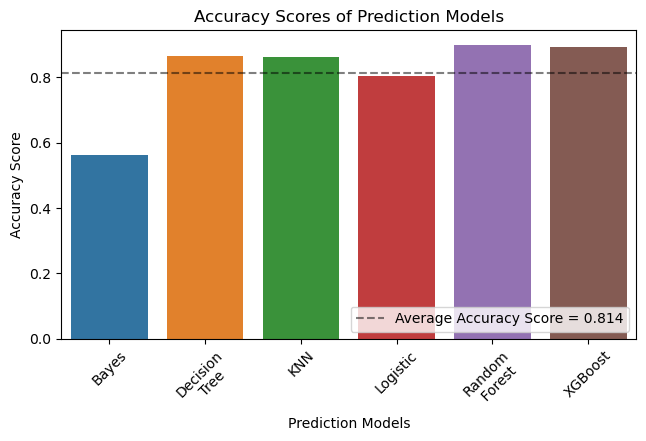

In [93]:
# Visualize accuracy
fig, ax = plt.subplots()
sns.barplot(x='Model', y='accuracy', data=model_results_df, ax=ax)
plt.xticks(rotation=45)
plt.xlabel('Prediction Models')
plt.ylabel('Accuracy Score')
plt.axhline(model_results_df['accuracy'].mean(), linestyle='--', color='black', alpha=0.5, 
            label=f"Average Accuracy Score = {round(model_results_df['accuracy'].mean(), 3)}")
plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0))
plt.title('Accuracy Scores of Prediction Models')

plt.tight_layout(pad=0.5)

x_tick_labels = ['Bayes', 'Decision\n Tree', 'KNN', 'Logistic', 'Random\n Forest', 'XGBoost']
ax.set_xticklabels(x_tick_labels, rotation=45)

plt.savefig('accuracy_models.png', dpi=300, bbox_inches='tight')
plt.show()


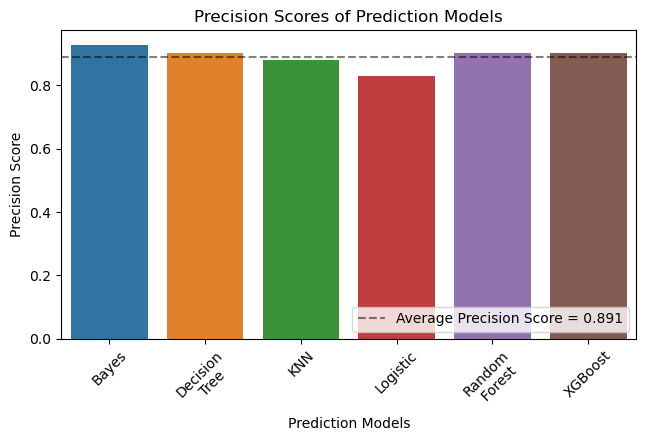

In [92]:
# Visualize precision
fig, ax = plt.subplots()
sns.barplot(x='Model', y='precision', data=model_results_df, ax=ax)
plt.xticks(rotation=45)
plt.xlabel('Prediction Models')
plt.ylabel('Precision Score')
plt.axhline(model_results_df['precision'].mean(), linestyle='--', color='black', alpha=0.5, 
            label=f"Average Precision Score = {round(model_results_df['precision'].mean(), 3)}")
plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0))
plt.title('Precision Scores of Prediction Models')

plt.tight_layout(pad=0.5)

# Change x-axis tick labels
x_tick_labels = ['Bayes', 'Decision\n Tree', 'KNN', 'Logistic', 'Random\n Forest', 'XGBoost']
ax.set_xticklabels(x_tick_labels, rotation=45)

plt.savefig('precision_models.png', dpi=300, bbox_inches='tight')
plt.show()


<b>Comments:</b>
- `Decision Tree`, `Knn`, `Random Forest` and `XGBoost` have surpassed both the average value on accuracy and precision. We will consider these four models for ensemble.
- However, `KNN` took too much time for computation and it marked fourth for both accuracy and precision so it will be excluded from the ensemble.

## Best-Hyperparameters-Classifiers for Ensemble Models

In [38]:
# Instantiate the best-hyperparameters-classifiers to be stacked together
best_hyperparameters_xgb = XGBClassifier(random_state=817, objective='binary:logistic', learning_rate=0.3, 
                                         colsample_bytree=0.75, gamma=1, max_depth=13, n_estimators=200)
best_hyperparameters_dt = DecisionTreeClassifier(random_state=817, criterion='entropy', max_depth=24, 
                                                 min_samples_leaf=2, min_samples_split=1)
best_hyperparametrs_rf = RandomForestClassifier(random_state=817, min_samples_split=1, min_samples_leaf=1, 
                                                n_estimators=425,criterion='gini', max_depth=30)

# Assign the best-hyperparameter-classifiers to best_hyperparameter_estimator
best_hyperparameter_estimator = [('best_hyperparameters_xgb', best_hyperparameters_xgb), 
                                 ('best_hyperparameters_dt', best_hyperparameters_dt), 
                                 ('best_hyperparametrs_rf', best_hyperparametrs_rf)]

## Ensemble Model: Stacking Classifier Model

In [39]:
# Instantiate the Stacking-Classifier
sc = StackingClassifier(best_hyperparameter_estimator)

# Make a pipeline
sc_pipe = Pipeline([('preprocess', ct), ('sc', sc)])

# Instantiate the stacking-classifier model and fit
sc_model = sc_pipe
sc_model.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['type_of_meal_plan',
                                                   'required_car_parking_space',
                                                   'room_type_reserved',
                                                   'arrival_month',
                                                   'arrival_date',
                                                   'market_segm...
                                                               n_estimators=200,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=817, ...)),
                                                ('best_hyperparameters_dt',
                                                 DecisionTreeClassifier(criterion='entropy',
                                                                        max_depth=24,
                                                                        min_samples_leaf=2,
                                                                        min_samples_split=1,
                                                                        random_state=817)),
                                                ('best_hyperparametrs_rf',
                                                 RandomForestClassifier(max_depth=30,
                                                                        min_samples_split=1,
                                                                        n_estimators=425,
                                                                        random_state=817))]))])

In [40]:
# Cross_validate
perform_cross_validation(sc_model, X_train, y_train)

Accuracy:       0.901
Precision:      0.912
Recall:         0.944
F1 Score:       0.928
ROC AUC Score:  0.955


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      3922
           1       0.91      0.95      0.93      8049

    accuracy                           0.90     11971
   macro avg       0.89      0.87      0.88     11971
weighted avg       0.90      0.90      0.90     11971




Stacking Classifier's Metrics:
accuracy:  0.899
precision: 0.906
recall:    0.948
f1:        0.926
roc:       0.952 




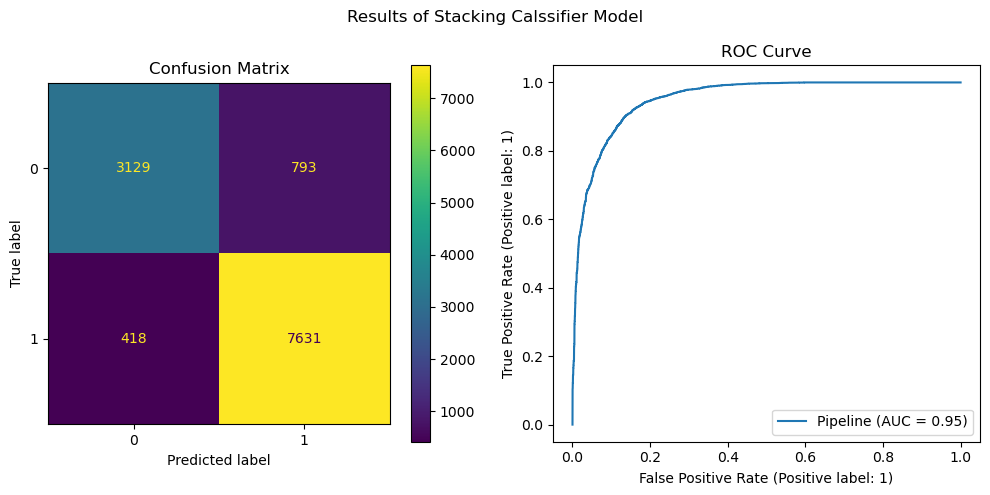

In [41]:
# Predict y-values
y_pred_sc = sc_model.predict(X_test)
y_pred_proba_sc = sc_model.predict_proba(X_test)[:,1]

# Print classification report on the best model
print_classification_report(y_test, y_pred_sc)

# Print test metrics and store it in a dictionary
test_results('stacking classifier', y_test, y_pred_sc, y_pred_proba_sc)

# Display confusion matrix and roc-auc curve
visualize_test_results("stacking calssifier", sc_model, X_test, y_test)

## Ensemble Model: Voting Classifier Model

In [42]:
# Instantiate the voting classifier
voting = VotingClassifier(best_hyperparameter_estimator, voting='soft')

# Make a pipeline
voting_pipe = Pipeline([('preprocess', ct), ('voting', voting)])

# Instantiate the voting-classifier model and fit
voting_model = voting_pipe
voting_model.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['type_of_meal_plan',
                                                   'required_car_parking_space',
                                                   'room_type_reserved',
                                                   'arrival_month',
                                                   'arrival_date',
                                                   'market_segm...
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=817, ...)),
                                              ('best_hyperparameters_dt',
                                               DecisionTreeClassifier(criterion='entropy',
                                                                      max_depth=24,
                                                                      min_samples_leaf=2,
                                                                      min_samples_split=1,
                                                                      random_state=817)),
                                              ('best_hyperparametrs_rf',
                                               RandomForestClassifier(max_depth=30,
                                                                      min_samples_split=1,
                                                                      n_estimators=425,
                                                                      random_state=817))],
                                  voting='soft'))])

In [43]:
# Cross_validate
perform_cross_validation(voting_model, X_train, y_train)

Accuracy:       0.894
Precision:      0.908
Recall:         0.936
F1 Score:       0.922
ROC AUC Score:  0.952


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      3922
           1       0.90      0.94      0.92      8049

    accuracy                           0.89     11971
   macro avg       0.89      0.87      0.88     11971
weighted avg       0.89      0.89      0.89     11971




Voting Classifier's Metrics:
accuracy:  0.893
precision: 0.903
recall:    0.943
f1:        0.922
roc:       0.951 




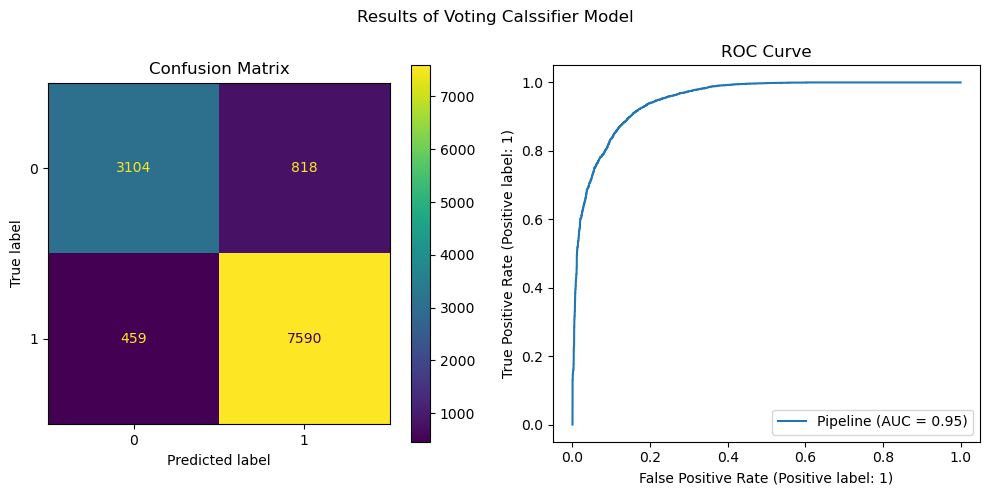

In [44]:
# Predict y-values
y_pred_voting = voting_model.predict(X_test)
y_pred_proba_voting = voting_model.predict_proba(X_test)[:,1]

# Print classification report on the best model
print_classification_report(y_test, y_pred_voting)

# Print test metrics and store it in a dictionary
test_results('voting classifier', y_test, y_pred_voting, y_pred_proba_voting)

# Display confusion matrix and roc-auc curve
visualize_test_results("voting calssifier", voting_model, X_test, y_test)

## Ensemble Model: Gradient Boosting

In [45]:
# Instantiate the Gradient Boosting Classifier and set the individual models as its base estimators
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=817)
boosted_estimator = [('best_hyperparameters_xgb', best_hyperparameters_xgb), 
                     ('best_hyperparameters_dt', best_hyperparameters_dt), 
                     ('best_hyperparametrs_rf', best_hyperparametrs_rf)]
gb_voting = VotingClassifier(boosted_estimator, voting='soft')

# Make a pipeline
gb_voting_pipe = Pipeline([('preprocess', ct), ('gb_voting', gb_voting)])

# Fit the ensemble classifier to the training data
gb_voting_model = gb_voting_pipe
gb_voting_model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominal_pipeline',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['type_of_meal_plan',
                                                   'required_car_parking_space',
                                                   'room_type_reserved',
                                                   'arrival_month',
                                                   'arrival_date',
                                                   'market_segm...
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=817, ...)),
                                              ('best_hyperparameters_dt',
                                               DecisionTreeClassifier(criterion='entropy',
                                                                      max_depth=24,
                                                                      min_samples_leaf=2,
                                                                      min_samples_split=1,
                                                                      random_state=817)),
                                              ('best_hyperparametrs_rf',
                                               RandomForestClassifier(max_depth=30,
                                                                      min_samples_split=1,
                                                                      n_estimators=425,
                                                                      random_state=817))],
                                  voting='soft'))])

In [46]:
# Cross_validate
perform_cross_validation(gb_voting_model, X_train, y_train)

Accuracy:       0.894
Precision:      0.908
Recall:         0.936
F1 Score:       0.922
ROC AUC Score:  0.952


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      3922
           1       0.90      0.94      0.92      8049

    accuracy                           0.89     11971
   macro avg       0.89      0.87      0.88     11971
weighted avg       0.89      0.89      0.89     11971




Gradient Boost's Metrics:
accuracy:  0.893
precision: 0.903
recall:    0.943
f1:        0.922
roc:       0.951 




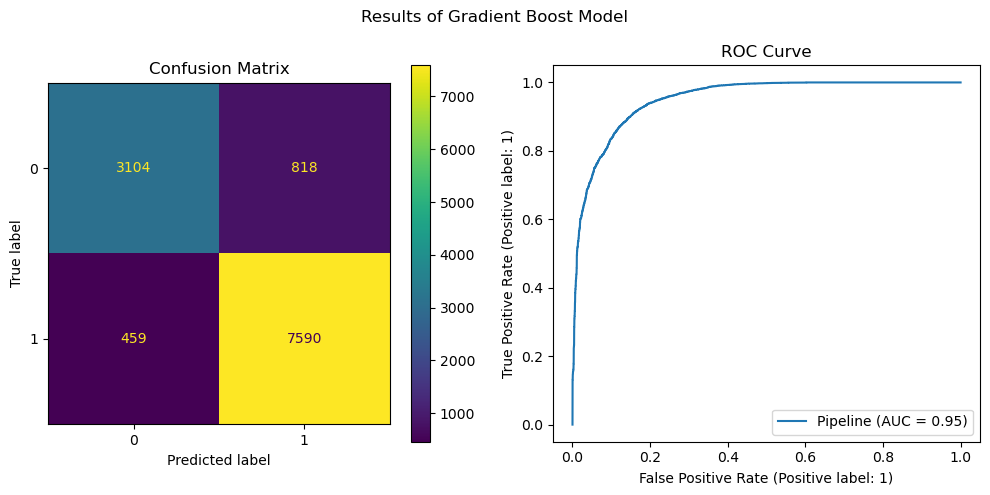

In [47]:
# Predict y-values
y_pred_gb_voting = gb_voting_model.predict(X_test)
y_pred_proba_gb_voting = gb_voting_model.predict_proba(X_test)[:,1]

# Print classification report on the best model
print_classification_report(y_test, y_pred_gb_voting)

# Print test metrics and store it in a dictionary
test_results('gradient boost', y_test, y_pred_gb_voting, y_pred_proba_gb_voting)

# Display confusion matrix and roc-auc curve
visualize_test_results("gradient boost", gb_voting_model, X_test, y_test)

We will now compare the ensemble model and choose our final model.

In [48]:
# Create a dataframe of ensemble results
ensemble_results_df = pd.DataFrame({'model':['stacking', 'voting', 'gradient boost'],
                                    'accuracy':[0.899, 0.893 , 0.893],
                                    'precision':[0.906, 0.903, 0.903]})

# Display the results
display(ensemble_results_df )

,model,accuracy,precision
0,stacking,0.899,0.906
1,voting,0.893,0.903
2,gradient boost,0.893,0.903


The metrics confirm a clear advantage for `stacking classifier` model.
It yielded the highest of both the accuracy and precision.

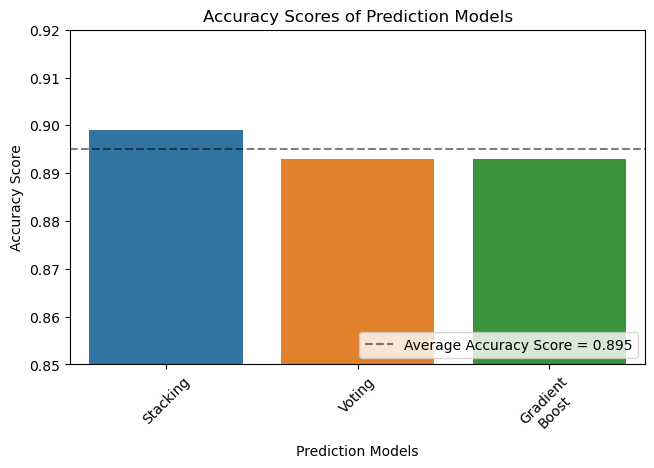

In [90]:
# Visualize accuracy
fig, ax = plt.subplots()
sns.barplot(x='model', y='accuracy', data=ensemble_results_df, ax=ax)
plt.xticks(rotation=45)
plt.xlabel('Prediction Models')
plt.ylabel('Accuracy Score')
plt.axhline(ensemble_results_df['accuracy'].mean(), linestyle='--', color='black', alpha=0.5, 
            label=f"Average Accuracy Score = {round(ensemble_results_df['accuracy'].mean(), 3)}")
plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0))
plt.title('Accuracy Scores of Prediction Models')

plt.tight_layout(pad=0.5)

x_tick_labels = ['Stacking', 'Voting', 'Gradient\nBoost']
ax.set_xticklabels(x_tick_labels, rotation=45)

# Set y-axis limits
ax.set_ylim([0.85, 0.92])

plt.savefig('accuracy_ensembles.png', dpi=300, bbox_inches='tight')
plt.show()


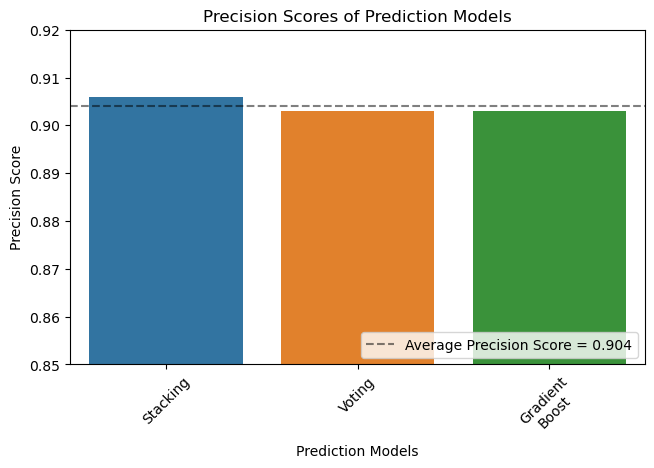

In [91]:
# Visualize accuracy
fig, ax = plt.subplots()
sns.barplot(x='model', y='precision', data=ensemble_results_df, ax=ax)
plt.xticks(rotation=45)
plt.xlabel('Prediction Models')
plt.ylabel('Precision Score')
plt.axhline(ensemble_results_df['precision'].mean(), linestyle='--', color='black', alpha=0.5, 
            label=f"Average Precision Score = {round(ensemble_results_df['precision'].mean(), 3)}")
plt.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0))
plt.title('Precision Scores of Prediction Models')

plt.tight_layout(pad=0.5)

x_tick_labels = ['Stacking', 'Voting', 'Gradient\nBoost']
ax.set_xticklabels(x_tick_labels, rotation=45)

# Set y-axis limits
ax.set_ylim([0.85, 0.92])

plt.savefig('precision_ensembles.png', dpi=300, bbox_inches='tight')
plt.show()


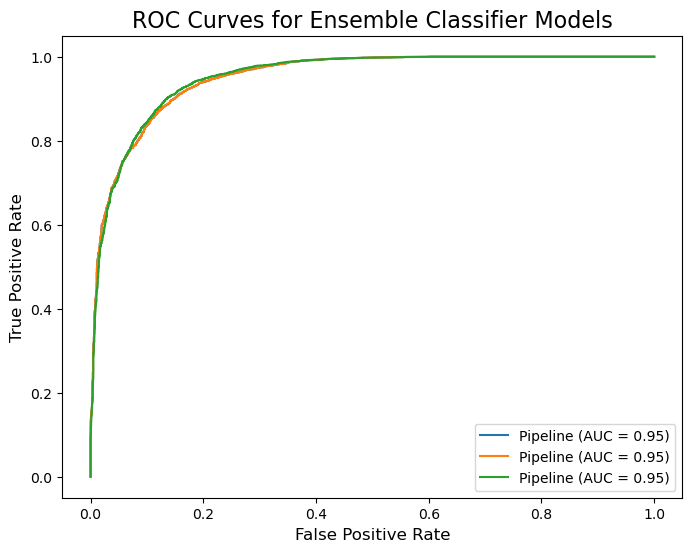

In [57]:
# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the ROC curve for each model
RocCurveDisplay.from_estimator(gb_voting_model, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(voting_model, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(sc_model, X_test, y_test, ax=ax)

# Add labels and title
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves for Ensemble Classifier Models', fontsize=16)

# Show the plot
plt.show()


<b>Comments:</b>
- All three ensemble models work better than any of the individual models.
- `Stacking Classifier` does best in both accuracy and precision.
- However, difference in performances are not dramatic.
- `Voting Classifier` was the second best performer at much quicker pace. If the stakeholder wants a quick and economic computation, then this model should be recommended.

## Final Model: `Stacking Classifier`

`stacking classifier` is our final model, as it outperforms other models on all important metrics.
We will look little deepr into this model, paying closer attention to each feature.

In [85]:
# Call feature importances from each model put into ensemble
dt_model_importance = dt_model.named_steps['dt'].feature_importances_
rf_model_importance = rf_model.named_steps['rf'].feature_importances_
xgb_model_importance = xgb_model.named_steps['xgb'].feature_importances_

# Take weighted averages of those features
feature_importance = (dt_model_importance + rf_model_importance + xgb_model_importance) / 3

# Get feature names
feature_name = ct.get_feature_names_out()

# Create a dataframe and organize by the order of importance
feature_df = pd.DataFrame({'feature_name': feature_name, 'feature_importance': feature_importance})
feature_df = feature_df.sort_values('feature_importance', ascending=False)

# Print most important features
print("The most impactful features determining cancellation:")
display(feature_df.head(25))

# Print least important features
print("\n"*5 + "The least impactful features determining cancellation:")
display(feature_df.tail(25))

The most impactful features determining cancellation:


,feature_name,feature_importance
60,numeric_pipeline__lead_time,0.215581
63,numeric_pipeline__avg_price_per_room,0.112246
54,nominal_pipeline__market_segment_type_Online,0.090805
64,numeric_pipeline__no_of_special_requests,0.089444
59,numeric_pipeline__no_of_week_nights,0.034429
53,nominal_pipeline__market_segment_type_Offline,0.031558
20,nominal_pipeline__arrival_month_12,0.029761
58,numeric_pipeline__no_of_weekend_nights,0.028222
3,nominal_pipeline__required_car_parking_space_Yes,0.024648
56,numeric_pipeline__no_of_adults,0.023018







The least impactful features determining cancellation:


,feature_name,feature_importance
29,nominal_pipeline__arrival_date_10,0.005363
42,nominal_pipeline__arrival_date_23,0.005345
44,nominal_pipeline__arrival_date_25,0.005187
45,nominal_pipeline__arrival_date_26,0.005057
7,nominal_pipeline__room_type_reserved_Room_Type 5,0.004971
26,nominal_pipeline__arrival_date_7,0.004881
34,nominal_pipeline__arrival_date_15,0.004866
23,nominal_pipeline__arrival_date_4,0.004856
32,nominal_pipeline__arrival_date_13,0.004835
37,nominal_pipeline__arrival_date_18,0.004747


We noticed some important features are:
- Month of Arrival
- Reservation Segment Type
- Lead Time
- Average Price Per Night
- Number of Special Requests

We also noticed some less important features:
- Meal Plan Types
- Number of Previous Cancellations
- Room Types

Now we will dig dipper into the features that impact our final model by making their visualizations and using them to make recommendations to Hilton.

# Conclusion

In this part, we will make meaningful recommendations to Hilton and emphasize any noteworthy discoveries.

## Recommendation 1: Focus on strategies to improve summer reservations.

In [95]:
# Call the original dataframe to do unbiased study
df = df_copy

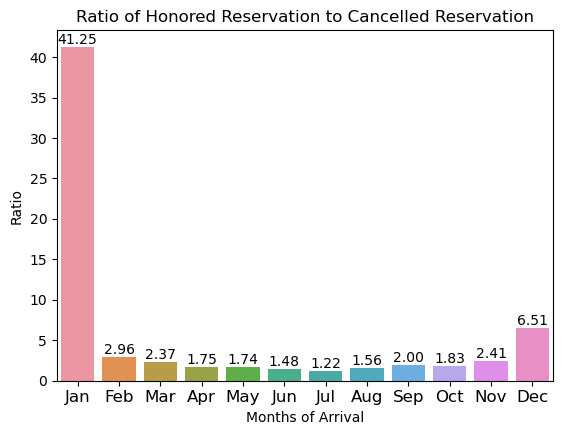

In [64]:
# group data by month and booking status
grouped = df.groupby(['arrival_month', 'booking_status']).size().reset_index(name='count')

# pivot the table to have booking status as columns
pivoted = grouped.pivot(index='arrival_month', columns='booking_status', values='count')

# calculate the ratio of Not_Canceled to Canceled for each month
pivoted['ratio'] = pivoted['Not_Canceled'] / pivoted['Canceled']

# create a barplot of the ratio for each month
sns.barplot(x=pivoted.index, y='ratio', data=pivoted)

# add annotations to the top of each bar
for i, v in enumerate(pivoted['ratio']):
    plt.annotate("{:.2f}".format(v), (i, v), ha='center', va='bottom', fontsize=10)

plt.title("Ratio of Honored Reservation to Cancelled Reservation")
plt.xlabel("Months of Arrival")
plt.ylabel("Ratio")

# set the xticks to month names
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(len(months)), months, fontsize=12)

# set the yticks fontsize
plt.yticks(fontsize=10)

# adjust the bottom margin
plt.subplots_adjust(bottom=0.15)

plt.savefig('ratio_cancel_month.png')
plt.show()


- January reservation confirmation is off the chart.
- Winter time reservation confirmations are more reliable than other times of the year.
- Summer time, especially near peak vacation times, there are too many cancellations.
- We believe there needs to be more focus and strategic approaches in dealing with reservations made for summer visits.

## Recommendation 2: Make business people come. Enhance their experiences.

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


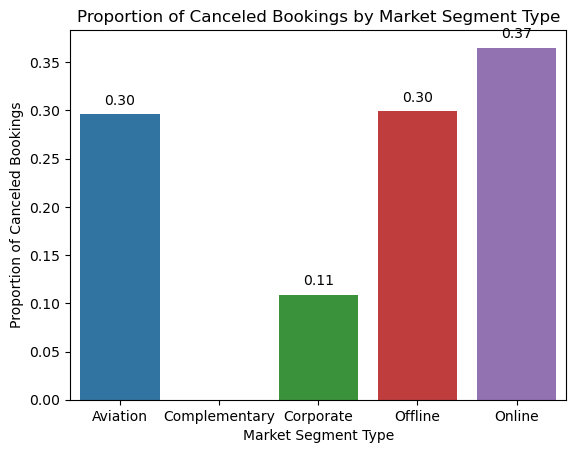

In [96]:
# calculate the proportion of canceled bookings for each value of no_of_special_requests
prop_df = df.groupby(['market_segment_type', 'booking_status']).size().reset_index(name='count')
prop_df = prop_df.pivot(index='market_segment_type', columns='booking_status', values='count')
prop_df['proportion'] = prop_df['Canceled'] / (prop_df['Not_Canceled'] + prop_df['Canceled'])

# create a bar plot of the proportion of canceled bookings
ax = sns.barplot(x=prop_df.index, y='proportion', data=prop_df)

# set axis labels and title
ax.set(xlabel='Market Segment Type', ylabel='Proportion of Canceled Bookings', 
       title='Proportion of Canceled Bookings by Market Segment Type')

# add annotations to the bars
for i, v in enumerate(prop_df['proportion']):
    if i == 1: # add annotation for the second bar
        ax.text(i, v+0.01, "0", ha='center')
    else:
        ax.text(i, v+0.01, "{:.2f}".format(v), ha='center')

# show the plot
plt.savefig('market_segment.png')
plt.show()


- Free rooms are never cancelled.
- Business travelers are three times less likely to cancel their reservations compared to people who make their reservations through other segment type.
- We believe that Hilton should develope strategies on satisfying needs of business travelers, hopefully even offerring opportunities for business conventions.

## Recommendation 3: Price rooms just before steep increase in cancellation rate.

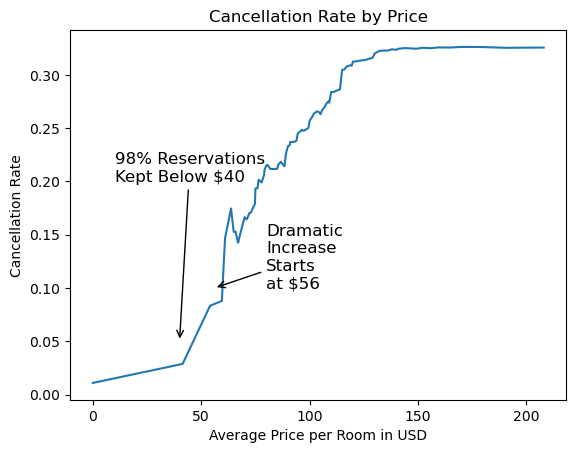

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Compute percentiles of avg_price_per_room column
percentiles = np.arange(1, 100)
price_percentiles = np.percentile(df['avg_price_per_room'], percentiles)

# Initialize lists to store percentile and cancellation rate
percentile_values = []
cancellation_rates = []

# Compute cancellation rate at each price percentile
for percentile in price_percentiles:
    # Filter DataFrame to include only bookings with avg_price_per_room less than or equal to the percentile
    subset_df = df[df['avg_price_per_room'] <= percentile]
    
    # Compute cancellation rate for the filtered DataFrame
    cancellation_counts = subset_df.groupby('booking_status').size()
    cancellation_rate = cancellation_counts.get('Canceled', 0) / cancellation_counts.sum()
    
    # Store percentile and cancellation rate in lists
    percentile_values.append(percentile)
    cancellation_rates.append(cancellation_rate)

# Plot cancellation rate vs. percentile
plt.plot(percentile_values, cancellation_rates)
plt.xlabel('Average Price per Room in USD')
plt.ylabel('Cancellation Rate')
plt.title('Cancellation Rate by Price')

# Add arrow and text label
plt.annotate('Dramatic\nIncrease\nStarts\nat $56', xy=(56, 0.1), xytext=(80, 0.1), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)
plt.annotate('98% Reservations\nKept Below $40', xy=(40, 0.05), xytext=(10, 0.2), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)


plt.savefig('cancel_rate_threshold.png')
plt.show()


- Reservations for room price below $40 are kept 98% of the times.
- Once a neighborhood for pricing is determined, choose specifically a price point right before a sharp increase in cancellation rate. We do not want to expose ourselves to much greater cancellation chances at the cost of couple extra bucks.

## Discovery 1: Reservations made 5 months prior are recipe for cancellations.

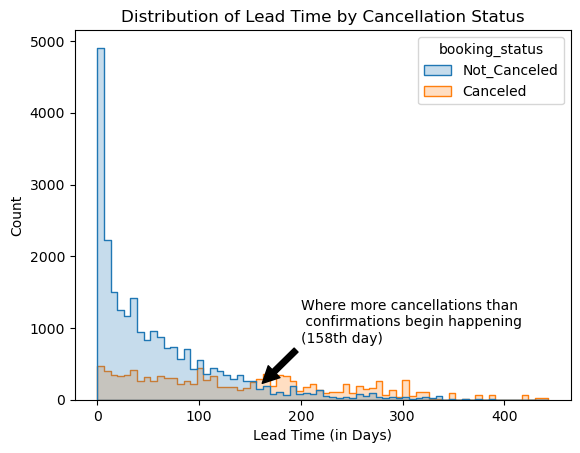

In [67]:
sns.histplot(x='lead_time', hue='booking_status', data=df, element='step')
plt.title('Distribution of Lead Time by Cancellation Status')
plt.xlabel('Lead Time (in Days)')
plt.ylabel('Count')

plt.annotate('Where more cancellations than\n confirmations begin happening\n(158th day)',
             xy=(160, 200), xytext=(200, 800),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.savefig('dist_leadtime_cancel2.png')
plt.show()


- Considering that reservations are twice more likey to be kept, the inflection point near at 5-month mark suggests an important warning.
- Reservations made five months prior or even earlier are very likely to be cancelled.

## Discovery 2: Special requests are welcome!

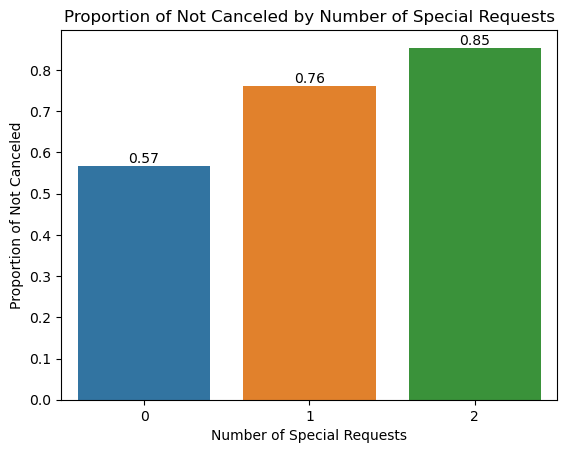

In [71]:
# group data by no_of_special_requests and booking status
grouped = df.groupby(['no_of_special_requests', 'booking_status']).size().reset_index(name='count')

# pivot the table to have booking status as columns
pivoted = grouped.pivot(index='no_of_special_requests', columns='booking_status', values='count')

# calculate the proportion of booking status for each value of no_of_special_requests
pivoted['proportion'] = pivoted['Not_Canceled'] / (pivoted['Canceled'] + pivoted['Not_Canceled'])

# filter pivoted dataframe to only include values for 0, 1, and 2
pivoted_filtered = pivoted[pivoted.index.isin([0,1,2])]

# create a barplot of the proportion of booking status for values of 0, 1, and 2
sns.barplot(x=pivoted_filtered.index, y='proportion', data=pivoted_filtered)

# add annotations to the top of each bar
for i, v in enumerate(pivoted_filtered['proportion']):
    plt.annotate("{:.2f}".format(v), (i, v), ha='center', va='bottom', fontsize=10)

# set axis labels and title
plt.xlabel('Number of Special Requests')
plt.ylabel('Proportion of Not Canceled')
plt.title('Proportion of Not Canceled by Number of Special Requests')

# show the plot
plt.savefig('special_requests.png')
plt.show()


- Any customer-specific requests are not welcome to the businesses.
- However, in this specific case of dealing with cancellations, higher number of special requests guarantee non-cancellations. It could be possible that specific plans and expectations of customers equate to reservation confirmations.

# Next Steps

<b>For better correctness:</b>
- To increase the correctness of my model, I can search for more data which contains more person-specific information about person the reservation such as:
  - Person's 'Loyalty Program' status
  - Person's demographic information
  - Geographic location where reservation was made
  - Time it took for reservation to be made from the start (for online reservations)
  
- Maybe different ensemble methods can be used to enhance performance. This project will continue to be updated for hyperparameter tuning on ensemble. 

<b>For better generalizations:</b>
- This model was built based only on data generated from a single hotel. It could be overfitting to this specific hotel. To be generalized for predictions all across the globe, data from different hotels from different countries can help a lot.

